# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 

##  Project F: Measuring the Shape and Brightness of Galaxies with Neural Networks
### Ideation 1
### Group 75: Dmitry Vukolov, Ning Xu, Rohit Beri, Sunil Chomal


**Harvard University**<br/>
**Spring 2020**<br/>
**Instructors**: Pavlos Protopapas, Mark Glickman and Chris Tanner<br/>


<hr style="height:2pt">

---



In [1]:
# RUN THIS CELL
import requests
from IPython.core.display import HTML, display

styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css"
).text
HTML(styles)

## <div class="theme"> Outline </div> 

1. Overview
2. Loading the Data
3. Structure and Size of the Data
4. Basic Statistics of the Data 
5. Visualization of the Image Data 
6. Distributions of the Labels and Numerical Attributes 
7. Parametric Image Generation
8. Summary

## <div class="theme"> Overview </div> 

<div style="border: 3px solid #800080; padding: 10px"> 

## Creating Galaxy images using Galsim

### <div class='exercise'> <b> Step 0: Load the essential libraries </b> </div>

In [2]:
# Load useful libraries
import os
import sys
import copy
import math
import time
import random
import numpy as np
import pandas as pd
import ipywidgets as widgets

# Import h5py for reading h5 files
import h5py

# Load galsim for data generation
import galsim

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Tweak plot resolution and styling
%config InlineBackend.figure_format = "retina"
sns.set(style="white", palette=None, rc={"axes.linewidth": 1})
plt.rc("image", cmap="viridis")

In [3]:
# Load useful libraries
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from tensorflow.keras.metrics import *
from tensorflow.keras.callbacks import EarlyStopping

### <div class='exercise'> <b> Step 1: Load the data </b> </div>

In [4]:
# Read the data set
dataset = "./cs109b-project/data/data_v1.npz"

with np.load(dataset) as data:
    print("Available variables:", data.files)

    image = data["img"]
    image_nonoise = data["img_nonoise"]
    label = data["label"]
    snr = data["snr"]
    sigma = data["sigma"]
    psf = data["psf_r"]

Available variables: ['img', 'img_nonoise', 'label', 'psf_r', 'snr', 'sigma', 'train_test']


In [5]:
# Reshape images to 3D array
image = image.reshape(image.shape[0], image.shape[1], image.shape[2], 1)
image_nonoise = image_nonoise.reshape(image_nonoise.shape[0], image_nonoise.shape[1], image_nonoise.shape[2], 1)

# Split into 90% train and 10% test (creates a view of the array)
n_train = int(label.shape[0] * 0.9)
image_train, image_val = image[:n_train], image[n_train:]
image_nonoise_train, image_nonoise_val = image_nonoise[:n_train], image_nonoise[n_train:]
label_train, label_val = label[:n_train], label[n_train:]
snr_train, snr_val = snr[:n_train], snr[n_train:]
sigma_train, sigma_val = sigma[:n_train], sigma[n_train:]
psf_train, psf_val = psf[:n_train], psf[n_train:]


# Zero-One Normalization of the labels
label_min = label.min(axis=0)
label_max = label.max(axis=0)
label_diff = (label_max - label_min)

label_train = (label_train - label_min)/label_diff
label_val = (label_val - label_min)/label_diff


# Zero-One Normalization of the no-noise images
image_nonoise_min = image_nonoise.min()
image_nonoise_max = image_nonoise.max()
image_nonoise_diff = (image_nonoise_max - image_nonoise_min)

image_nonoise_train = (image_nonoise_train - image_nonoise_min)/image_nonoise_diff
image_nonoise_val = (image_nonoise_val - image_nonoise_min)/image_nonoise_diff


# Zero-One Normalization of the noisy images
image_min = image.min()
image_max = image.max()
image_diff = (image_max - image_min)

image_train = (image_train - image_min)/image_diff
image_val = (image_val - image_min)/image_diff

### <div class='exercise'> <b> Step 2: Structure and Size of the Data </b> </div>

In [6]:
# Structure and Size of the Data
print("Image Shape            = {}".format(image.shape))
print("No-noise Image Shape   = {}".format(image_nonoise.shape))
print("Label Shape            = {}".format(label.shape))
print("SNR Shape              = {}".format(snr.shape))
print("Sigma Shape            = {}".format(sigma.shape))
print("PSF-R Shape            = {}".format(psf.shape))

Image Shape            = (200000, 64, 64, 1)
No-noise Image Shape   = (200000, 64, 64, 1)
Label Shape            = (200000, 5)
SNR Shape              = (200000,)
Sigma Shape            = (200000,)
PSF-R Shape            = (200000,)


### <div class='exercise'> <b> Step 3: Basic Statistics of the Data </b> </div>

In [7]:
# Gather the image and attribute tables for processing
tables = {
    "Image": image,
    "No-noise Image": image_nonoise,
    "SNR": snr,
    "Sigma": sigma,
    "PSF-R": psf,
}
# Map each of the five labels to their names
labels = pd.DataFrame(label, columns=["Flux", "Sersic Index", "Sersic Radius", "g1", "g2"])

# Compute basic statistics
stats = {name: [data.mean(), data.var(), data.min(), data.max()] for name, data in tables.items()}
pd.concat(
    [
        pd.DataFrame.from_dict(stats, orient="index", columns=["mean", "var", "min", "max"]),
        labels.agg(["mean", "var", "min", "max"]).T,
    ]
).rename_axis("Data Type").rename(columns=lambda x: x.title()).round(2)

,Mean,Var,Min,Max
Data Type,,,,
Image,26.12,7.813868e+04,-1197.36,8133.71
No-noise Image,26.12,3.810756e+04,-0.15,7783.52
SNR,58.23,5.812000e+02,12.23,100.00
Sigma,200.00,0.000000e+00,200.00,200.00
PSF-R,0.50,0.000000e+00,0.50,0.50
Flux,108535.80,2.378915e+09,30000.67,251822.86
Sersic Index,3.25,2.530000e+00,0.50,6.00
Sersic Radius,0.38,2.000000e-02,0.10,0.60
g1,0.00,8.000000e-02,-0.67,0.67


### <div class='exercise'> <b> Step 4: Create Data Pipeline </b> </div>

In [8]:
def pipeline_label_to_clean_image(element):
    image = element['No-noise Image']
    label = tf.cast(element['Labels'], tf.float32)
    return (label, image)

In [9]:
def pipeline_clean_image_to_label(element):
    image = element['No-noise Image']
    label = tf.cast(element['Labels'], tf.float32)
    return (image, label)

In [10]:
training = tf.data.Dataset.from_tensor_slices({
    "Image": image_train,
    "No-noise Image": image_nonoise_train,
    "Labels": label_train,
    "SNR": snr_train,
    "Sigma": sigma_train,
    "PSF-R": psf_train,
})

validation = tf.data.Dataset.from_tensor_slices({
    "Image": image_val,
    "No-noise Image": image_nonoise_val,
    "Labels": label_val,
    "SNR": snr_val,
    "Sigma": sigma_val,
    "PSF-R": psf_val,
})

In [11]:
batch_size = 256

tr_ds = training.map(pipeline_label_to_clean_image
                               ).shuffle(1024).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_ds = validation.map(pipeline_label_to_clean_image
                           ).shuffle(1024).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

### <div class='exercise'> <b> Step 5: Create Label to Image Encoder </b> </div>

In [12]:
input_shape = (64,64,1)
dropout = 0.5

# Encoder Output dimension
latent_z_dim = 5

# Decoder latent dimension
latent_dim = (1,1,2048)

epochs = 20

In [13]:
class ConvEncoder(layers.Layer):
    """
    Convolutional Encoder Layer Class.
    Converts an input into a latent representation.
    """

    def __init__(self, input_shape, dropout_rate=0.0, name='encoder', **kwargs):
        """
        Initializes the encoder layers and saves them as local attribute.
        
        Input:
        -input_dim: 3D-tuple with (rows, cols, channels) input image dimensions.
        
        Returns nothing.
        """
        super(ConvEncoder, self).__init__(name=name, input_shape=input_shape, **kwargs)
        
        ## your code here
        
        self.conv1 = layers.Conv2D(filters=9, kernel_size=(5,5), activation='relu', padding='same', strides=(2,2))
        self.drop1 = layers.Dropout(dropout_rate)
        
        self.conv2 = layers.Conv2D(filters=18, kernel_size=(5,5), activation='relu', padding='same', strides=(2,2))
        self.drop2 = layers.Dropout(dropout_rate)
        
        self.conv3 = layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu', padding='same', strides=(2,2))
        self.drop3 = layers.Dropout(dropout_rate)
        
        self.conv4 = layers.Conv2D(filters=64, kernel_size=(5,5), activation='relu', padding='same', strides=(2,2))
        self.drop4 = layers.Dropout(dropout_rate)
        
        # end of your code here
        

    def call(self, inputs, training=None):
        """
        Runs the encoding inference for `inputs`.
        
        Inputs:
        -inputs: 4D-tensor with dimension (batch_size, self.input_dim).
        """
        ## your code here
        
        z = self.conv1(inputs)
        z = self.drop1(z)
        z = self.conv2(z)
        z = self.drop2(z)
        z = self.conv3(z)
        z = self.drop3(z)       
        z = self.conv4(z)
        z = self.drop4(z)     
        
        # end of your code here
        return z

In [14]:
class ConvDecoder(layers.Layer):
    """
    Convolutional Decoder Layer Class.
    Converts z, the encoded digit vector, back into a readable digit.
    """

    def __init__(self, input_shape, dropout_rate=0.0, name='decoder', **kwargs):
        """
        Initializes the decoder architecture and saves it as a local attribute.
        
        Input:
        -input_shape: 3D-tuple with (rows, cols, channels) input representation.
        
        Returns nothing.
        """
        super(ConvDecoder, self).__init__(name=name, input_shape=input_shape, **kwargs)
        
        # your code here
        self.convT1 = layers.Conv2DTranspose(512, kernel_size=(3,3), strides=(2,2), padding='same')
        self.lRelu1 = layers.LeakyReLU()
        self.drop1 = layers.Dropout(dropout_rate)
        
        self.convT2 = layers.Conv2DTranspose(256, kernel_size=(3,3), strides=(2,2), padding='same')
        self.lRelu2 = layers.LeakyReLU()
        self.drop2 = layers.Dropout(dropout_rate)
        
        self.convT3 = layers.Conv2DTranspose(128, kernel_size=(3,3), strides=(2,2), padding='same')
        self.lRelu3 = layers.LeakyReLU()
        self.drop3 = layers.Dropout(dropout_rate)
        
        self.convT4 = layers.Conv2DTranspose(64, kernel_size=(3,3), strides=(2,2), padding='same')
        self.lRelu4 = layers.LeakyReLU()
        self.drop4 = layers.Dropout(dropout_rate)
        
        self.convT5 = layers.Conv2DTranspose(32, kernel_size=(3,3), strides=(2,2), padding='same')
        self.lRelu5 = layers.LeakyReLU()
        self.drop5 = layers.Dropout(dropout_rate)
        
        self.convT6 = layers.Conv2DTranspose(1, kernel_size=(3,3), strides=(2,2), padding='same', 
                                             activation='sigmoid')
        # end of your code here
        

    def call(self, inputs, training=None):
        """
        Runs the encoding inference for `inputs`.
        
        Inputs:
        -inputs: 4D-tensor with dimension (batch_size, self.input_dim).
        """
        ## your code here
        
        x = self.convT1(inputs)
        x = self.lRelu1(x)
        x = self.drop1(x)
        
        x = self.convT2(x)
        x = self.lRelu2(x)
        x = self.drop2(x)
        
        x = self.convT3(x)
        x = self.lRelu3(x)
        x = self.drop3(x)
        
        x = self.convT4(x)
        x = self.lRelu4(x)
        x = self.drop4(x)
        
        x = self.convT5(x)
        x = self.lRelu5(x)
        x = self.drop5(x)
        
        x = self.convT6(x)
        
        # end your code here
        return x

In [15]:
class Sampling(layers.Layer):
    """
    Sampling layer in latent space.
    Uses (z_mean, z_log_var) to sample z.
    """

    def call(self, inputs):
        """Rturns a random sample from a Gaussian with mean and 
        log-variance indicated in inputs.
        
        Inputs:
        -inputs: tuple (z_mean, z_log_var)
        
        Returns a sample z drawn from Gaussian.
        """
        z_mean, z_log_var = inputs

        # your code here
        
        shape = tf.shape(z_mean)
        epsilon = K.random_normal(shape=shape)
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [16]:
K.clear_session()

# Create VAE Model
def create_VAE(name, reg=0):
    # Create Encoder
    input_layer = layers.Input(shape=input_size)
    enc = ConvEncoder(input_size)(input_layer)
    x = layers.Flatten()(enc)
    z_mean = layers.Dense(latent_z_dim, activation="linear")(x)
    z_log_var = layers.Dense(latent_z_dim, activation="linear")(x)
    latent_z = Sampling()((z_mean, z_log_var))

    # Create Encoder
    input_decoder = layers.Input(latent_z_dim)
    x = layers.Dense(1024, activation='relu')(input_decoder)
    x = layers.Reshape(latent_dim)(x)
    recon = ConvDecoder(latent_dim)(x)
    
    # Encoder Model
    encoder = tf.keras.Model(input_layer, latent_z, name=name+'_encoder')
    display(encoder.summary())
    
    # Decoder Model
    decoder = tf.keras.Model(input_decoder, recon, name=name+'_decoder')
    display(decoder.summary())
    
    # VAE Model
    latent_rep = encoder(input_layer)
    z_decoded = decoder(latent_rep)
    
    VAE = tf.keras.Model(input_layer, z_decoded, name=name)
    display(VAE.summary())
    
    # Add KL divergence regularization loss if specified.
    if reg:
        kl_loss = - reg * 0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        VAE.add_loss(kl_loss)
    
    # Compile the model
    optimizer = optimizers.Adam(learning_rate=0.001)
    VAE.compile(optimizer, loss=losses.MeanSquaredError())
    
    # Return Variational-AE, encoder and decoder
    return VAE, encoder, decoder

In [17]:
# Create Reverse Decoder Model
def create_reverse_decoder():

    # Create Reverse Decoder
    input_decoder = layers.Input(latent_z_dim)
    x = layers.Dense(1024)(input_decoder)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(2048)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Reshape(latent_dim)(x)
    recon = ConvDecoder(latent_dim)(x)
    
    # Decoder Model
    decoder = tf.keras.Model(input_decoder, recon, name='Reverse_Decoder')
    display(decoder.summary())
    
    # Compile the model
    optimizer = optimizers.Adam(learning_rate=0.001)
    decoder.compile(optimizer, loss=losses.BinaryCrossentropy())
    
    # Return Variational-AE, encoder and decoder
    return decoder

reverse_decoder = create_reverse_decoder()

Model: "Reverse_Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              6144      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              2099200   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
reshape (Reshape)            (None, 1, 1, 2048)    

None

In [18]:
# Run the model
try:
    reverse_decoder.load_weights('./model/rev_de')
    
except:
    history = reverse_decoder.fit(
        tr_ds, 
        epochs=epochs, 
        verbose=1,
        validation_data=val_ds,
        callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
    )
    
    reverse_decoder.save_weights('./model/rev_de')

In [21]:
test = val_ds.take(1)
labels, images = next(iter(test))
pred = reverse_decoder.predict(labels)
pred = pred.reshape(pred.shape[:-1])

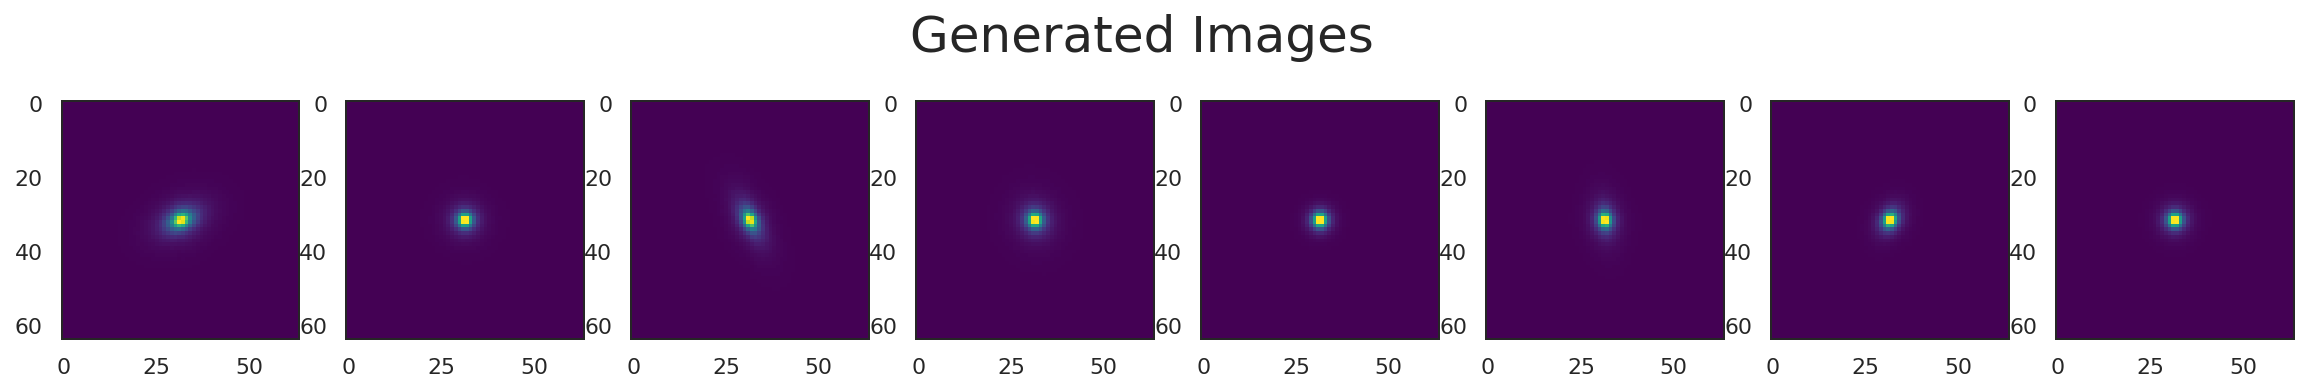

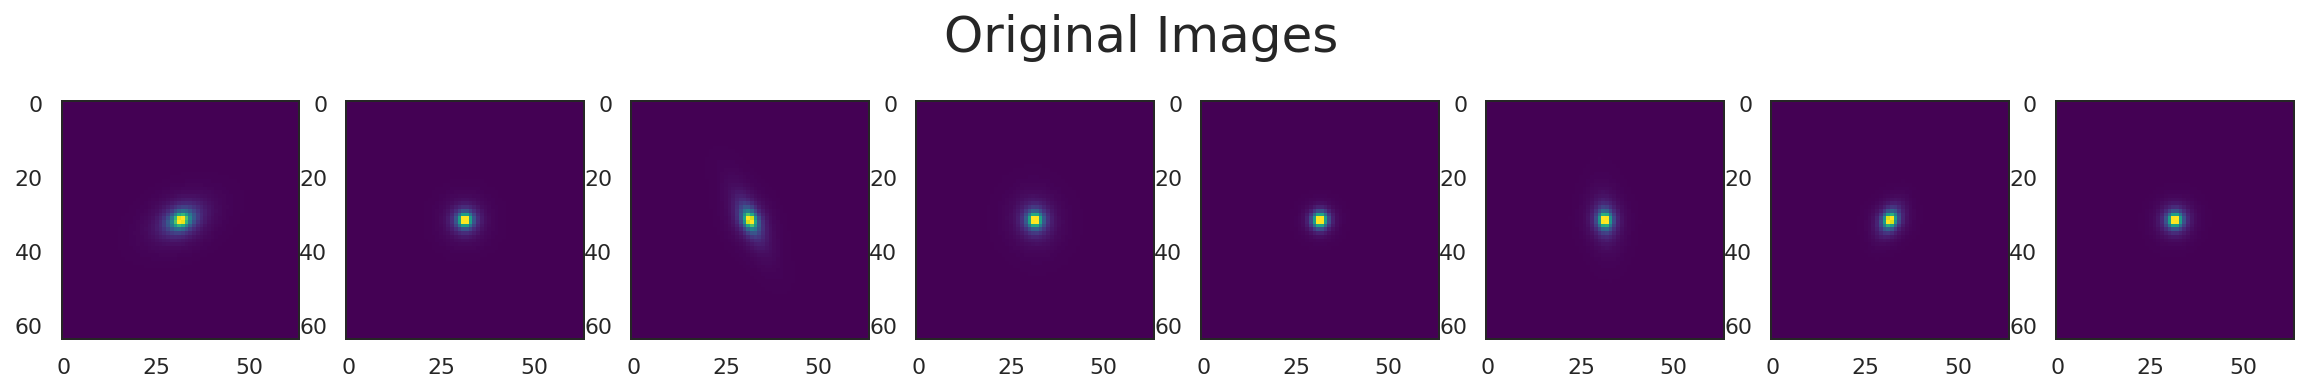

In [28]:
idx = np.random.randint(256*1, size=8)

fig, ax = plt.subplots(1,8, figsize=(20,3))
plt.suptitle("Generated Images", fontsize=25)
for j in range(8):
    ax[j].imshow(pred[idx[j]])
plt.show()


fig, ax = plt.subplots(1,8, figsize=(20,3))
plt.suptitle("Original Images", fontsize=25)
for j in range(8):
    ax[j].imshow(images[idx[j]].numpy().reshape(64,64))
plt.show()

### <div class='exercise'> <b> Step 4: Visualization of the Image Data </b> </div>

<div class='gc'> <b> Select random images for visualization </b> </div>

## <div class="theme"> Summary </div> 

<div style="border: 3px solid #800080; padding: 10px"> 
    
### ***Shape and Brightness of a Galaxy***


# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png">  End of Exploratory Data Analysis 
